# Micrograd Implementation Notebook

## Necessary libraries

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Derivative with one input

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

f(3.0)

20.0

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

Text(0.5, 1.0, '$f(x)=3x^2-4x+5$')

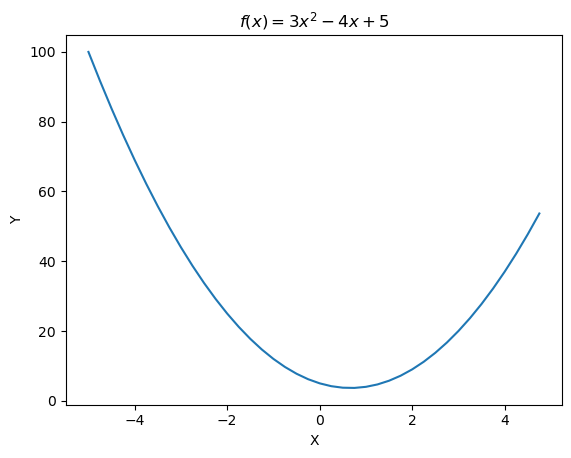

In [4]:
plt.plot(xs, ys)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('$f(x)=3x^2-4x+5$')

No one in real life tries to find the derivatives by hand. To calculate it we need to understand what the derivative does.

For example we can take our `x=3` and a very small `h=0.001`. If we plug it to our function $f(x+h)$ we will see that the value has slightly increased. Therefore slightly going in a positive direction will increase the value for our function. 

We can take $\large\frac{f(x+h)-f(x)}{h}$ to obrain the slope of the function, which is roughly 14.
If we differentiate by hand, we can see that the approximation is correct:

$f(x)'=6x-4$

$f(3.0)=18-4=14$

In [5]:
h = 0.00000001
x = 3.0
f(x + h)

20.00000014

In [6]:
(f(x + h) - f(x)) / h

14.00000009255109

In [7]:
h = 0.00000001
x = -3.0
f(x + h)

43.999999779999996

In [8]:
(f(x + h) - f(x)) / h

-22.00000039920269

We can find where the slop is zero by solving the $f(x)'=0$

The answer is $\large\frac{2}{3}$

In [9]:
h = 0.00000001
x = 2 / 3
f(x + h)

3.666666666666667

In [10]:
(f(x + h) - f(x)) / h

0.0

## Derivative with Multiple Inputs

In [11]:
h=0.0001
a = 2.0
b = -3.0
c = 10.0
d1 = a * b + c
print('d1:',d1)
a += h # Derivative of d with respect to a
d2 = a * b + c
print('d2:',d2)
print('slope: ', (d2 - d1) / h)

d1: 4.0
d2: 3.999699999999999
slope:  -3.000000000010772


## Value object for micrograd

In [186]:
import math
class Value:
    """ stores a single scalar value and its gradient """

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        # internal variables used for autograd graph construction
        self._backward = lambda: None
        self._prev = set(_children)
        self.label = label
        self._op = _op # the op that produced this node, for graphviz / debugging / etc

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self, ), 'exp')

        def _backward():
            self.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1) / (math.exp(2*n)+1)
        out=Value(t, (self, ), 'tanh')
        def _backward():
            self.grad += (1-out.data**2) * out.grad
        out._backward = _backward
        
        return out
    

    def backward(self):

        # topological order all of the children in the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad})"
    

def trace(root):
    # Build the set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(node):
        if node not in nodes:
            nodes.add(node)
            for child in node._prev:
                edges.add((child, node))
                build(child)

    build(root)
    return nodes, edges

In [187]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a * b
e.label = 'e'
d = e + c  # a.__mul__(b).__add__(c)
d.label='d'
f = Value(-2.0, label='f')
L = d * f
L.label='L'

## Vizualization of Propogation

In [58]:
from graphviz import Digraph


def trace(root):
    # Build the set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(node):
        if node not in nodes:
            nodes.add(node)
            for child in node._prev:
                edges.add((child, node))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format='png', graph_attr={'rankdir':
                                            'LR'})  # LR means Left-to-Right
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # If value, create a rectangular node
        dot.node(name=uid, label=f'{{ {n.label} | data {n.data:.4f} | grad {n.grad:.4f} }}', shape='record')
        if n._op:
            # If operation, create circular node
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)),
                 str(id(n2)) + n2._op)  # Connect Nodes throught the operation
        
#     if you uncomment the below code you'll be able to download the graph
#     graph_name = "computation_graph"
#     dot.render(filename=graph_name, directory="images", cleanup=True)
    
    return dot

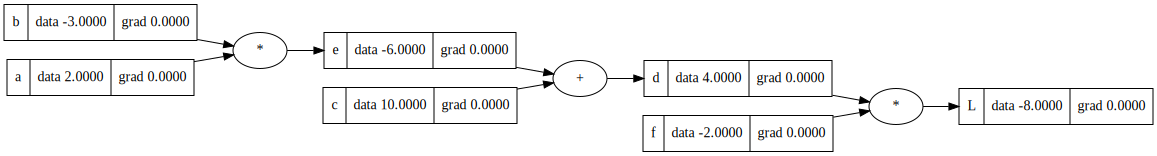

In [59]:
draw_dot(L)

## Manual Backpropogation

$\large\frac{dL}{dL}=1$

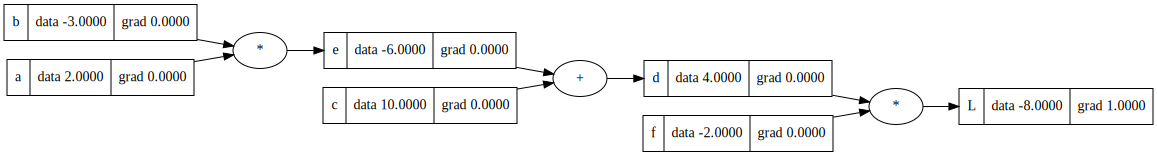

In [60]:
L.grad=1
draw_dot(L)

$L = df$

$\large\frac{dL}{dd}=f=-2;  \large\frac{dL}{df}=d=4$

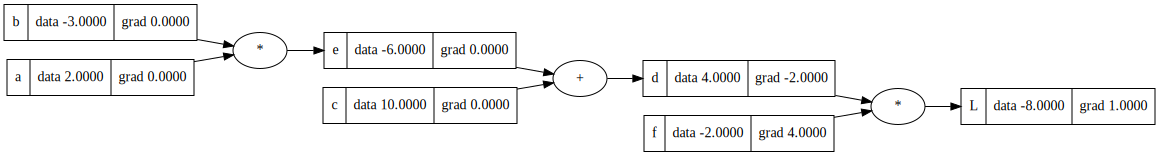

In [61]:
f.grad=4.0
d.grad=-2.0
draw_dot(L)

$\large\frac{dL}{dc}=\frac{dL}{dd}\frac{dd}{dc}=-2.0*1=-2.0$

$\large\frac{dL}{de}=\frac{dL}{dd}\frac{dd}{de}=-2.0*1=-2.0$

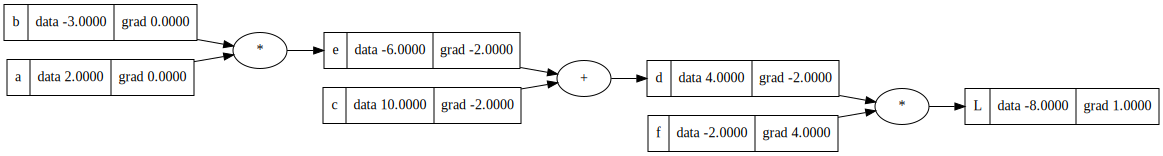

In [62]:
c.grad=-2.0
e.grad=-2.0
draw_dot(L)

$\large\frac{dL}{da}=\frac{dL}{dd}\frac{dd}{de}\frac{de}{da}=(-2.0)(1.0)(-3.0)=6.0$

$\large\frac{dL}{db}=\frac{dL}{dd}\frac{dd}{de}\frac{de}{db}=(-2.0)(1.0)(2.0)=-4.0$

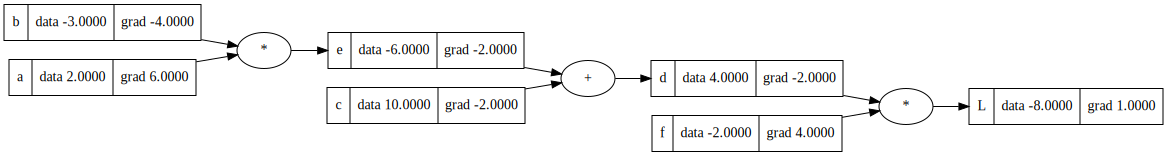

In [63]:
a.grad=6.0
b.grad=-4.0
draw_dot(L)

In [64]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad
e = a * b
d = e + c
L = d * f
print(L.data)

-7.286496


In [65]:
def gradient_check():
    h = 0.000001
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c  # a.__mul__(b).__add__(c)
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L1 = L.data

    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a * b
    e.label = 'e'
    d = e + c  # a.__mul__(b).__add__(c)
    d.label = 'd'
    f = Value(-2.0, label='f')
    L = d * f
    L.label = 'L'
    L2 = L.data

    print((L2 - L1) / h)


gradient_check()

0.0


## Backpropogating through a neuron

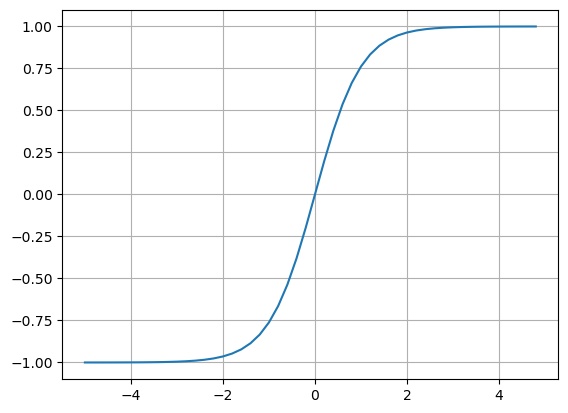

In [188]:
plt.plot(np.arange(-5.0, 5, 0.2), np.tanh(np.arange(-5, 5, 0.2)))
plt.grid();

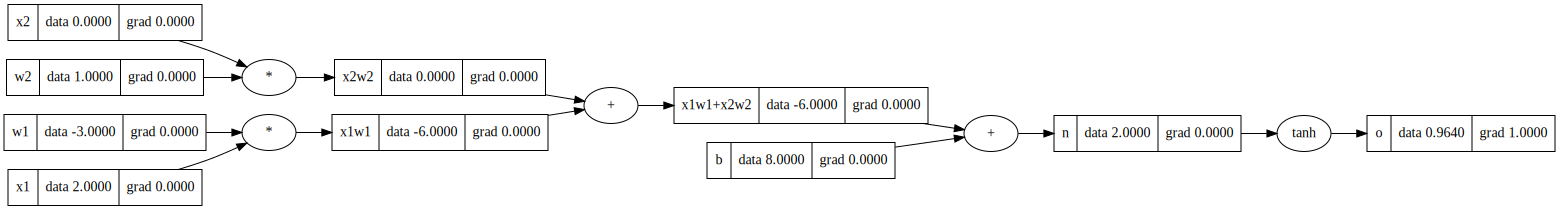

In [189]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(8.0, label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1w1'
x2w2 = x2 * w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b
n.label = 'n'
o = n.tanh()
o.label='o'
o.grad = 1.0

draw_dot(o)

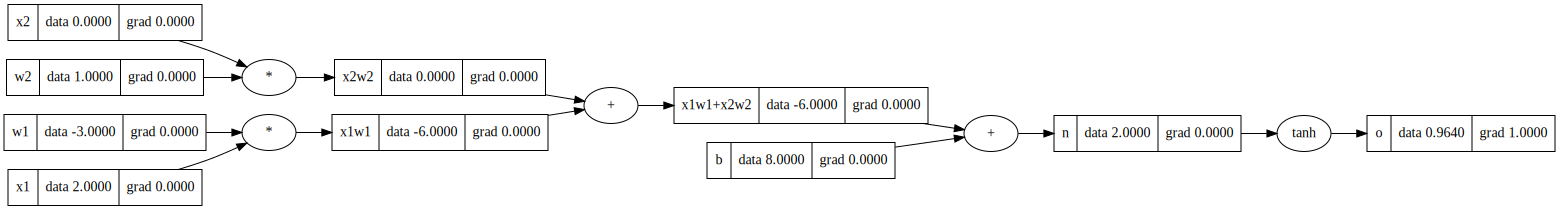

In [190]:
o.grad=1.0
draw_dot(o)

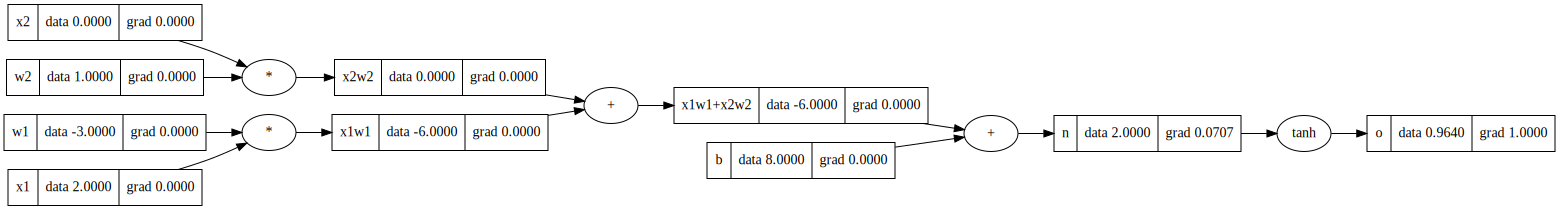

In [191]:
n.grad = 1-o.data**2
draw_dot(o)

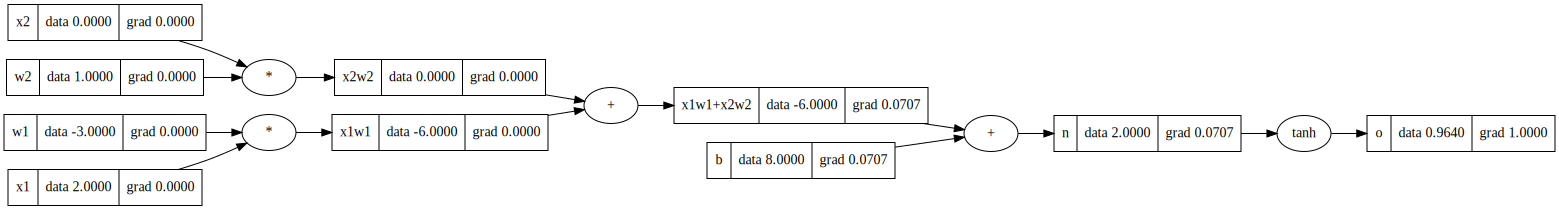

In [192]:
b.grad=0.0707
x1w1x2w2.grad=0.0707
draw_dot(o)

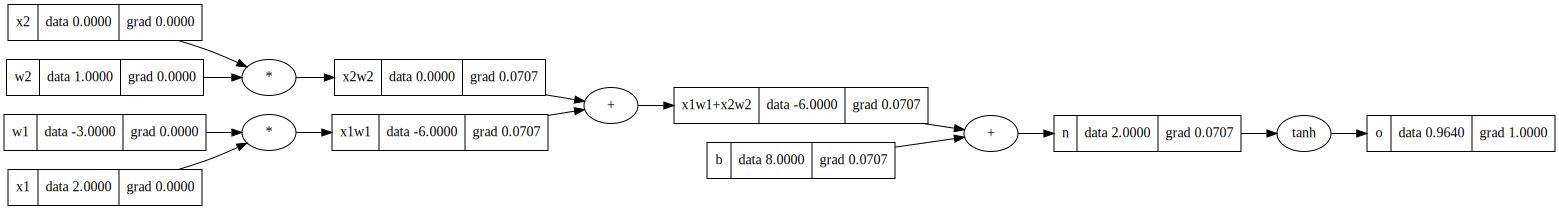

In [193]:
x1w1.grad=0.0707
x2w2.grad=0.0707
draw_dot(o)

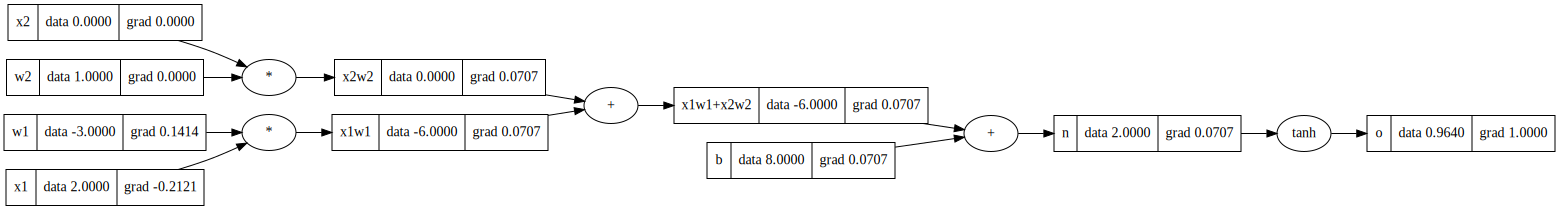

In [194]:
x1.grad = x1w1.grad*w1.data
w1.grad = x1w1.grad*x1.data
draw_dot(o)

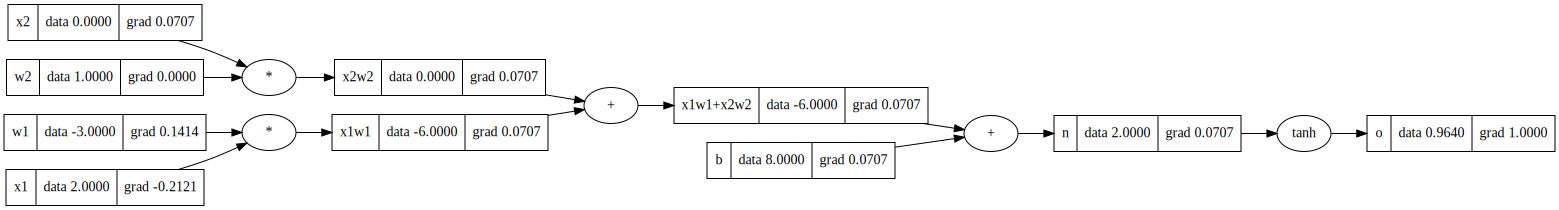

In [195]:
x2.grad = x2w2.grad*w2.data
w2.grad = x2w2.grad*x2.data
draw_dot(o)

## Implementing Backward Propogation for the entire expression

The below code will be implemented inside the Value class above

In [196]:
o.grad=1.0
topo = list()
visited = set()
def build_topological_sort(vertex):
    if vertex not in visited:
        visited.add(vertex)
        for child in vertex._prev:
            build_topological_sort(child)
        topo.append(vertex)
        
build_topological_sort(o)
topo

[Value(data=8.0, grad=0.0707),
 Value(data=0.0, grad=0.0707),
 Value(data=1.0, grad=0.0),
 Value(data=0.0, grad=0.0707),
 Value(data=-3.0, grad=0.1414),
 Value(data=2.0, grad=-0.2121),
 Value(data=-6.0, grad=0.0707),
 Value(data=-6.0, grad=0.0707),
 Value(data=2.0, grad=0.07065082485316443),
 Value(data=0.9640275800758169, grad=1.0)]

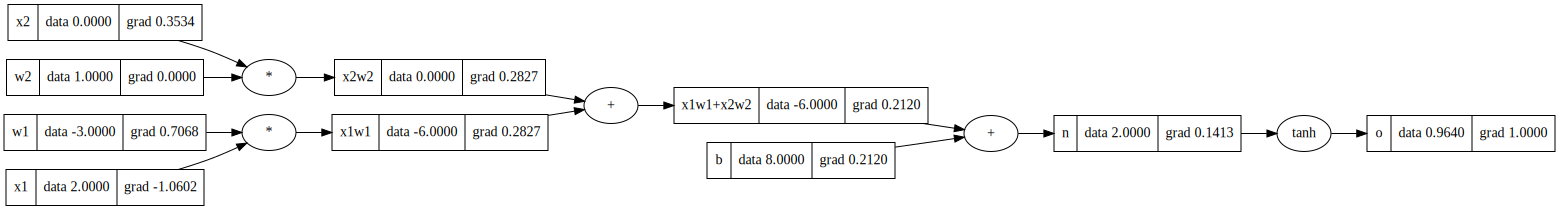

In [197]:
o.backward()
draw_dot(o)

In [198]:
x = Value(3)
q = Value(4)


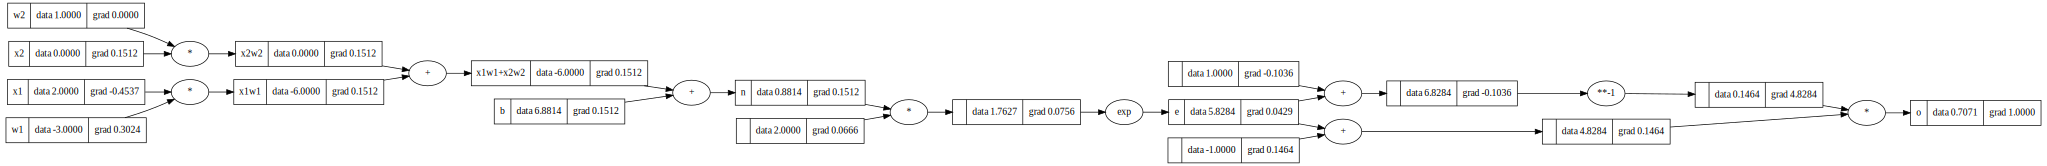

In [199]:
# Inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# Weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# Bias
b = Value(6.8813735870195432, label='b')

# x1w1 + x2w2 + b
x1w1 = x1 * w1
x1w1.label = 'x1w1'
x2w2 = x2 * w2
x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = 'x1w1+x2w2'
n = x1w1x2w2 + b
n.label = 'n'
e = (2*n).exp()
e.label='e'
o = (e - 1) / (e + 1)
o.label='o'
o.backward()
draw_dot(o)

## Pytorch implementation of micrograd

In [200]:
import torch

x1 = torch.Tensor([2.0]).double() # Python uses float64 instead of 32; therefore, we cast it to double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b1 = torch.Tensor([6.8813735870195432]).double()
b1.requires_grad = True
n = x1 * w1 + x2 * w2 + b1
o = torch.tanh(n)
print(o.data.item())
o.backward()
print('-' * 10)
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
----------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


## Neuron Implementation for Micrograd

In [201]:
import random


class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [215]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.500125717895315, grad=0)

In [216]:
len(n.parameters())

41

In [217]:
xs = [
    [2., 3., -1.],
    [3., -1., 0.5],
    [0.5, 1., 1.],
    [1., 1., -1.]
]
ys = [1., -1., -1., 1.]

y_pred = [n(x) for x in xs]
y_pred

[Value(data=-0.500125717895315, grad=0),
 Value(data=0.010934130006537571, grad=0),
 Value(data=0.05296482666250498, grad=0),
 Value(data=-0.723735336342726, grad=0)]

In [218]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_pred))

In [219]:
loss.backward()

In [221]:
loss

Value(data=7.352363420647979, grad=1.0)

In [222]:
n.layers[0].neurons[0].w[0].data

0.6298891537960987

In [223]:
for p in n.parameters():
    p.data += -0.01 * p.grad

In [224]:
n.parameters()

[Value(data=0.6276861980733973, grad=0.22029557227013996),
 Value(data=0.14247985178168907, grad=0.22108682357643697),
 Value(data=-0.7159417827227784, grad=0.28772651405576183),
 Value(data=0.9570681872171765, grad=0.28904207825260053),
 Value(data=0.1361935907796439, grad=0.20698078043665746),
 Value(data=-0.8169861066169137, grad=-1.0049459433201684),
 Value(data=-0.7781613166541099, grad=0.8265654086858196),
 Value(data=-0.4135085812230849, grad=-0.18232395265054707),
 Value(data=-0.576211375818651, grad=-0.5923890741626072),
 Value(data=0.577695383444034, grad=-1.241071498322192),
 Value(data=0.35599880824422325, grad=0.9677251100689415),
 Value(data=0.040121494232944345, grad=-0.0509199658972484),
 Value(data=-0.376185270374361, grad=0.6659154613417253),
 Value(data=-0.3524551570759722, grad=6.518839457661915),
 Value(data=-0.8504102432347376, grad=-4.365291442937846),
 Value(data=0.6197431037470096, grad=0.22205103593726294),
 Value(data=0.5693402658687644, grad=-0.2730893935941

## Gradient Descent

In [243]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)
xs = [
    [2., 3., -1.],
    [3., -1., 0.5],
    [0.5, 1., 1.],
    [1., 1., -1.]
]
ys = [1., -1., -1., 1.]

In [244]:
for k in range(10):
    y_pred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, y_pred))
    
    for p in n.parameters():
        p.grad=0
    
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.05 * p.grad
        
    print(k, loss.data)

0 5.962957435742434
1 2.8367889107151063
2 0.6220173236185722
3 0.33354559394825
4 0.2376172319988082
5 0.18535803052247046
6 0.1522275473770352
7 0.12925554329434613
8 0.112350547542584
9 0.09936981336920848


In [247]:
y_pred

[Value(data=0.8538423510443532, grad=-0.2923152979112935),
 Value(data=-0.84240949644129, grad=0.3151810071174199),
 Value(data=-0.8539326106673404, grad=0.29213477866531923),
 Value(data=0.8215698848775245, grad=-0.35686023024495106)]